In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.PMF.pmf_model import logprior, loglikelihood
from models.PMF.util import R_train, R_test, load_PMF_MAP


from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed, flatten_param_list

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# PMF

In [2]:
data = (R_train,)


key = random.PRNGKey(0)
centering_value = load_PMF_MAP()
params_IC = load_PMF_MAP()

gridsearch_bs = int(0.1*R_train.shape[0])

T = 12

In [3]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)


def get_fb_grads_pmf(samples):
    """
    Return full-batch gradients for PMF samples
    samples list of PMF sample. Each PMF sample is a list of 6 arrays
    """
    return [grad_log_post(sam, R_train) for sam in samples]

def get_ksd_PMF(samples, thin_step):
    num_samples = len(samples)
    fb_grads = get_fb_grads_pmf(samples[::thin_step])
    flat_samples = flatten_param_list(samples[::thin_step])
    flat_grads = flatten_param_list(fb_grads)
    return imq_KSD(flat_samples, flat_grads)

def assess_PMF_samples(samples, thin_step):
    print(f"Assessing the samples. Num samples: {len(samples)}")
    ksd_est = get_ksd_PMF(samples, thin_step)
    return ksd_est
#     samples_array = jnp.array(samples[::thin_step])
#     pred_acc = accuracy(samples_array, X_test, y_test)
#     return ksd_est, pred_acc, std_error, len(samples)
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_PMF_MAP()):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_PMF_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

# time_budget = 5
# thin = 5

time_budget = 20
thin = 60


In [5]:
gridsearch_bs

8000

# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

In [ ]:
sh_params = {'batch_size': 8000, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, gridsearch_params))

In [ ]:
sh_params = {'batch_size': 8000, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, gridsearch_params))

In [ ]:
sh_params = {'batch_size': 80000, 'L': 10, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-5}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, gridsearch_params))

In [ ]:
sh_params = {'batch_size': 8000, 'L': 5, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-5}

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, gridsearch_params))

In [ ]:
sh_params = {'batch_size': 80000, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, gridsearch_params))

In [ ]:
sh_params = {'batch_size': 8000, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params))

# 2. KSD curves

### sgld

In [7]:
error_fn_ksd_curve = partial(get_ksd_PMF, thin_step=60)
list_time_budget = [2, 4, 6, 8, 10]

In [8]:
dict_params = {'batch_size': 8000, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 0.00031622776}

Iteration 0/10
Budget: 2, num_samples = 1000
Budget: 4, num_samples = 1970
Budget: 6, num_samples = 3053
Budget: 8, num_samples = 3811
Budget: 10, num_samples = 4826

Iteration 1/10
Budget: 2, num_samples = 1004
Budget: 4, num_samples = 1978
Budget: 6, num_samples = 2882
Budget: 8, num_samples = 3826
Budget: 10, num_samples = 4729

Iteration 2/10
Budget: 2, num_samples = 987
Budget: 4, num_samples = 1935
Budget: 6, num_samples = 2422
Budget: 8, num_samples = 3811
Budget: 10, num_samples = 3927

Iteration 3/10
Budget: 2, num_samples = 951
Budget: 4, num_samples = 1732
Budget: 6, num_samples = 2357
Budget: 8, num_samples = 3064
Budget: 10, num_samples = 3996

Iteration 4/10
Budget: 2, num_samples = 903
Budget: 4, num_samples = 1779
Budget: 6, num_samples = 2253
Budget: 8, num_samples = 3232
Budget: 10, num_samples = 4182

Iteration 5/10
Budget: 2, num_samples = 781
Budget: 4, num_samples = 1730
Budget: 6, num_samples = 2631
Budget: 8

In [14]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 0.00031622776}

Iteration 0/10
Budget: 2, num_samples = 984
Budget: 4, num_samples = 1904
Budget: 6, num_samples = 2737
Budget: 8, num_samples = 3687
Budget: 10, num_samples = 4722

Iteration 1/10
Budget: 2, num_samples = 977
Budget: 4, num_samples = 1948
Budget: 6, num_samples = 2548
Budget: 8, num_samples = 3795
Budget: 10, num_samples = 4685

Iteration 2/10
Budget: 2, num_samples = 975
Budget: 4, num_samples = 1800
Budget: 6, num_samples = 2529
Budget: 8, num_samples = 3733
Budget: 10, num_samples = 4765

Iteration 3/10
Budget: 2, num_samples = 958
Budget: 4, num_samples = 1872
Budget: 6, num_samples = 2553
Budget: 8, num_samples = 3701
Budget: 10, num_samples = 4637

Iteration 4/10
Budget: 2, num_samples = 952
Budget: 4, num_samples = 1794
Budget: 6, num_samples = 2528
Budget: 8, num_samples = 3659
Budget: 10, num_samples = 4588

Iteration 5/10
Budget: 2, num_samples = 956
Budget: 4, num_samples = 1819
Budget: 6, num_samples = 2567
Budget: 8, 

### sgld-cv

In [9]:
dict_params = {'batch_size': 800, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 1196
Budget: 4, num_samples = 2299
Budget: 6, num_samples = 3313
Budget: 8, num_samples = 4016
Budget: 10, num_samples = 4257

Iteration 1/10
Budget: 2, num_samples = 834
Budget: 4, num_samples = 1797
Budget: 6, num_samples = 2301
Budget: 8, num_samples = 3067
Budget: 10, num_samples = 3716

Iteration 2/10
Budget: 2, num_samples = 851
Budget: 4, num_samples = 1743
Budget: 6, num_samples = 2587
Budget: 8, num_samples = 2894
Budget: 10, num_samples = 4226

Iteration 3/10
Budget: 2, num_samples = 994
Budget: 4, num_samples = 1958
Budget: 6, num_samples = 2443
Budget: 8, num_samples = 2773
Budget: 10, num_samples = 4101

Iteration 4/10
Budget: 2, num_samples = 958
Budget: 4, num_samples = 1644
Budget: 6, num_samples = 2594
Budget: 8, num_samples = 3453
Budget: 10, num_samples = 4808

Iteration 5/10
Budget: 2, num_samples = 1020
Budget: 4, num_samples = 2006
Budget: 6, num_samples = 2918
Budget: 8, num_sam

In [16]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 0.00031622776}

Iteration 0/10
Budget: 2, num_samples = 644
Budget: 4, num_samples = 1187
Budget: 6, num_samples = 1607
Budget: 8, num_samples = 2287
Budget: 10, num_samples = 3032

Iteration 1/10
Budget: 2, num_samples = 630
Budget: 4, num_samples = 1182
Budget: 6, num_samples = 1820
Budget: 8, num_samples = 2258
Budget: 10, num_samples = 3012

Iteration 2/10
Budget: 2, num_samples = 629
Budget: 4, num_samples = 1193
Budget: 6, num_samples = 1806
Budget: 8, num_samples = 2243
Budget: 10, num_samples = 3001

Iteration 3/10
Budget: 2, num_samples = 584
Budget: 4, num_samples = 1195
Budget: 6, num_samples = 1819
Budget: 8, num_samples = 2228
Budget: 10, num_samples = 2816

Iteration 4/10
Budget: 2, num_samples = 578
Budget: 4, num_samples = 1115
Budget: 6, num_samples = 1697
Budget: 8, num_samples = 2147
Budget: 10, num_samples = 2631

Iteration 5/10
Budget: 2, num_samples = 550
Budget: 4, num_samples = 1218
Budget: 6, num_samples = 1785
Budget: 8, 

### sghmc

In [10]:
dict_params = {'batch_size': 800, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 354
Budget: 4, num_samples = 681
Budget: 6, num_samples = 850
Budget: 8, num_samples = 1005
Budget: 10, num_samples = 1288

Iteration 1/10
Budget: 2, num_samples = 264
Budget: 4, num_samples = 488
Budget: 6, num_samples = 673
Budget: 8, num_samples = 766
Budget: 10, num_samples = 1074

Iteration 2/10
Budget: 2, num_samples = 275
Budget: 4, num_samples = 456
Budget: 6, num_samples = 782
Budget: 8, num_samples = 1033
Budget: 10, num_samples = 1313

Iteration 3/10
Budget: 2, num_samples = 276
Budget: 4, num_samples = 570
Budget: 6, num_samples = 833
Budget: 8, num_samples = 1124
Budget: 10, num_samples = 1430

Iteration 4/10
Budget: 2, num_samples = 278
Budget: 4, num_samples = 531
Budget: 6, num_samples = 646
Budget: 8, num_samples = 1019
Budget: 10, num_samples = 1395

Iteration 5/10
Budget: 2, num_samples = 284
Budget: 4, num_samples = 558
Budget: 6, num_samples = 829
Budget: 8, num_samples = 

In [18]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 111
Budget: 4, num_samples = 220
Budget: 6, num_samples = 329
Budget: 8, num_samples = 434
Budget: 10, num_samples = 541

Iteration 1/10
Budget: 2, num_samples = 108
Budget: 4, num_samples = 212
Budget: 6, num_samples = 320
Budget: 8, num_samples = 428
Budget: 10, num_samples = 534

Iteration 2/10
Budget: 2, num_samples = 106
Budget: 4, num_samples = 214
Budget: 6, num_samples = 314
Budget: 8, num_samples = 425
Budget: 10, num_samples = 534

Iteration 3/10
Budget: 2, num_samples = 104
Budget: 4, num_samples = 204
Budget: 6, num_samples = 282
Budget: 8, num_samples = 370
Budget: 10, num_samples = 520

Iteration 4/10
Budget: 2, num_samples = 104
Budget: 4, num_samples = 210
Budget: 6, num_samples = 317
Budget: 8, num_samples = 430
Budget: 10, num_samples = 531

Iteration 5/10
Budget: 2, num_samples = 106
Budget: 4, num_samples = 218
Budget: 6, num_samples = 320
Budget: 8, num_samples = 426
Bud

### sghmc-CV

In [11]:
dict_params = {'batch_size': 80, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 326
Budget: 4, num_samples = 588
Budget: 6, num_samples = 794
Budget: 8, num_samples = 1054
Budget: 10, num_samples = 1362

Iteration 1/10
Budget: 2, num_samples = 283
Budget: 4, num_samples = 561
Budget: 6, num_samples = 796
Budget: 8, num_samples = 1039
Budget: 10, num_samples = 984

Iteration 2/10
Budget: 2, num_samples = 250
Budget: 4, num_samples = 531
Budget: 6, num_samples = 817
Budget: 8, num_samples = 1129
Budget: 10, num_samples = 1386

Iteration 3/10
Budget: 2, num_samples = 276
Budget: 4, num_samples = 550
Budget: 6, num_samples = 824
Budget: 8, num_samples = 1094
Budget: 10, num_samples = 1412

Iteration 4/10
Budget: 2, num_samples = 286
Budget: 4, num_samples = 558
Budget: 6, num_samples = 820
Budget: 8, num_samples = 1099
Budget: 10, num_samples = 1416

Iteration 5/10
Budget: 2, num_samples = 286
Budget: 4, num_samples = 570
Budget: 6, num_samples = 845
Budget: 8, num_samples = 1

In [20]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 81
Budget: 4, num_samples = 162
Budget: 6, num_samples = 242
Budget: 8, num_samples = 316
Budget: 10, num_samples = 397

Iteration 1/10
Budget: 2, num_samples = 76
Budget: 4, num_samples = 152
Budget: 6, num_samples = 228
Budget: 8, num_samples = 305
Budget: 10, num_samples = 379

Iteration 2/10
Budget: 2, num_samples = 73
Budget: 4, num_samples = 151
Budget: 6, num_samples = 228
Budget: 8, num_samples = 309
Budget: 10, num_samples = 386

Iteration 3/10
Budget: 2, num_samples = 75
Budget: 4, num_samples = 156
Budget: 6, num_samples = 231
Budget: 8, num_samples = 294
Budget: 10, num_samples = 375

Iteration 4/10
Budget: 2, num_samples = 79
Budget: 4, num_samples = 155
Budget: 6, num_samples = 229
Budget: 8, num_samples = 300
Budget: 10, num_samples = 377

Iteration 5/10
Budget: 2, num_samples = 78
Budget: 4, num_samples = 156
Budget: 6, num_samples = 228
Budget: 8, num_samples = 306
Budget: 1

### sgnht

In [12]:
dict_params = {'batch_size': 8000, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622778e-05}

Iteration 0/10
Budget: 2, num_samples = 961
Budget: 4, num_samples = 1883
Budget: 6, num_samples = 2715
Budget: 8, num_samples = 3267
Budget: 10, num_samples = 4109

Iteration 1/10
Budget: 2, num_samples = 843
Budget: 4, num_samples = 1683
Budget: 6, num_samples = 2489
Budget: 8, num_samples = 3444
Budget: 10, num_samples = 4093

Iteration 2/10
Budget: 2, num_samples = 889
Budget: 4, num_samples = 1757
Budget: 6, num_samples = 2528
Budget: 8, num_samples = 3321
Budget: 10, num_samples = 4162

Iteration 3/10
Budget: 2, num_samples = 892
Budget: 4, num_samples = 1773
Budget: 6, num_samples = 2540
Budget: 8, num_samples = 3328
Budget: 10, num_samples = 4247

Iteration 4/10
Budget: 2, num_samples = 843
Budget: 4, num_samples = 1728
Budget: 6, num_samples = 2562
Budget: 8, num_samples = 3343
Budget: 10, num_samples = 4260

Iteration 5/10
Budget: 2, num_samples = 841
Budget: 4, num_samples = 1728
Budget: 6, num_samples = 2583
Budget: 8, 

In [22]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 915
Budget: 4, num_samples = 1725
Budget: 6, num_samples = 2493
Budget: 8, num_samples = 2905
Budget: 10, num_samples = 3732

Iteration 1/10
Budget: 2, num_samples = 826
Budget: 4, num_samples = 1698
Budget: 6, num_samples = 2518
Budget: 8, num_samples = 3466
Budget: 10, num_samples = 4113

Iteration 2/10
Budget: 2, num_samples = 903
Budget: 4, num_samples = 1812
Budget: 6, num_samples = 2445
Budget: 8, num_samples = 3424
Budget: 10, num_samples = 3495

Iteration 3/10
Budget: 2, num_samples = 741
Budget: 4, num_samples = 1627
Budget: 6, num_samples = 2382
Budget: 8, num_samples = 3299
Budget: 10, num_samples = 3781

Iteration 4/10
Budget: 2, num_samples = 783
Budget: 4, num_samples = 1282
Budget: 6, num_samples = 2190
Budget: 8, num_samples = 3178
Budget: 10, num_samples = 4227

Iteration 5/10
Budget: 2, num_samples = 805
Budget: 4, num_samples = 1692
Budget: 6, num_samples = 2212
Budget: 8, 

### sgnht-CV

In [13]:
dict_params = {'batch_size': 8000, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 656
Budget: 4, num_samples = 1305
Budget: 6, num_samples = 1945
Budget: 8, num_samples = 2439
Budget: 10, num_samples = 2838

Iteration 1/10
Budget: 2, num_samples = 588
Budget: 4, num_samples = 1167
Budget: 6, num_samples = 1756
Budget: 8, num_samples = 2395
Budget: 10, num_samples = 2902

Iteration 2/10
Budget: 2, num_samples = 583
Budget: 4, num_samples = 1174
Budget: 6, num_samples = 1756
Budget: 8, num_samples = 2330
Budget: 10, num_samples = 2974

Iteration 3/10
Budget: 2, num_samples = 590
Budget: 4, num_samples = 1168
Budget: 6, num_samples = 1759
Budget: 8, num_samples = 2404
Budget: 10, num_samples = 2935

Iteration 4/10
Budget: 2, num_samples = 572
Budget: 4, num_samples = 1171
Budget: 6, num_samples = 1757
Budget: 8, num_samples = 2396
Budget: 10, num_samples = 2951

Iteration 5/10
Budget: 2, num_samples = 586
Budget: 4, num_samples = 1167
Budget: 6, num_samples = 1754
Budget: 8, num_samp

In [19]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 655
Budget: 4, num_samples = 1304
Budget: 6, num_samples = 1946
Budget: 8, num_samples = 2574
Budget: 10, num_samples = 3187

Iteration 1/10
Budget: 2, num_samples = 634
Budget: 4, num_samples = 1275
Budget: 6, num_samples = 1815
Budget: 8, num_samples = 2184
Budget: 10, num_samples = 2831

Iteration 2/10
Budget: 2, num_samples = 567
Budget: 4, num_samples = 1238
Budget: 6, num_samples = 1856
Budget: 8, num_samples = 2455
Budget: 10, num_samples = 2920

Iteration 3/10
Budget: 2, num_samples = 625
Budget: 4, num_samples = 1252
Budget: 6, num_samples = 1828
Budget: 8, num_samples = 2227
Budget: 10, num_samples = 2866

Iteration 4/10
Budget: 2, num_samples = 566
Budget: 4, num_samples = 1237
Budget: 6, num_samples = 1850
Budget: 8, num_samples = 2455
Budget: 10, num_samples = 2811

Iteration 5/10
Budget: 2, num_samples = 577
Budget: 4, num_samples = 1264
Budget: 6, num_samples = 1827
Budget: 8, 

In [30]:
mean_ksd_curve_sgnht_mamba

array([677.9127 , 435.69467, 340.27075, 286.84207, 252.23836],
      dtype=float32)

#### save and load ksd curves

In [14]:

# MAMBA
np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
           np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
           np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
           np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
           np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
           np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
           np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# gridsearch
# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

# mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgld.txt")
# mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
# mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
# mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
# mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
# mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")



# plots: KSD curves

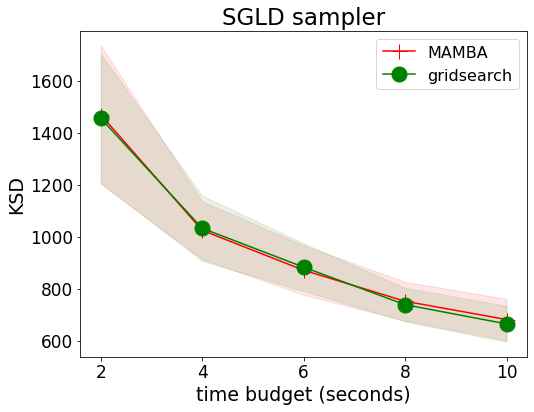

In [15]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

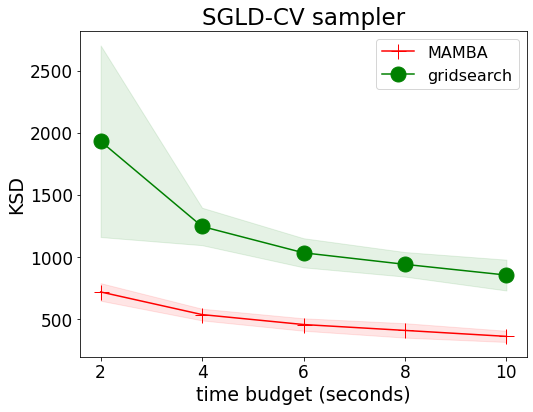

In [16]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

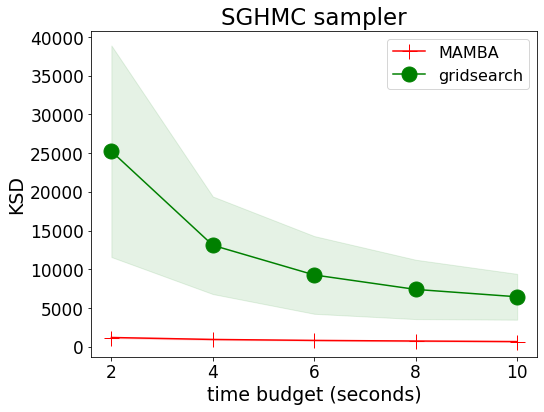

In [17]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')


plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

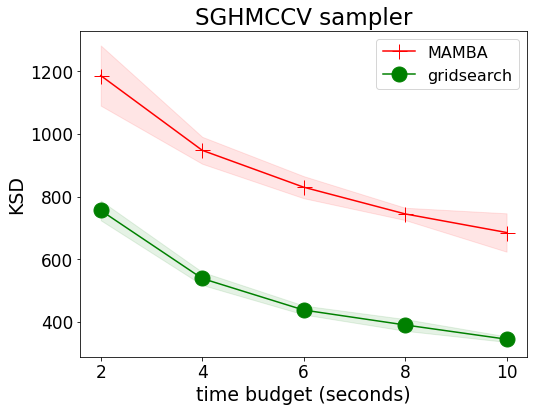

In [18]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')


plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

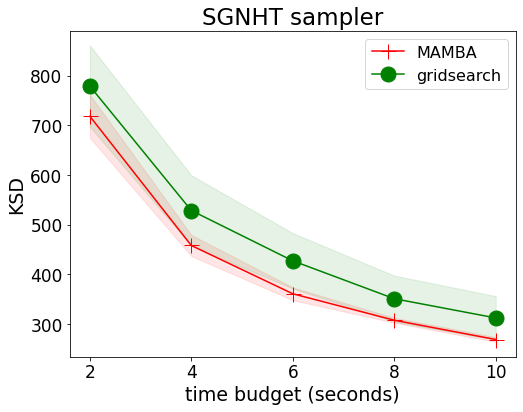

In [19]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')


plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

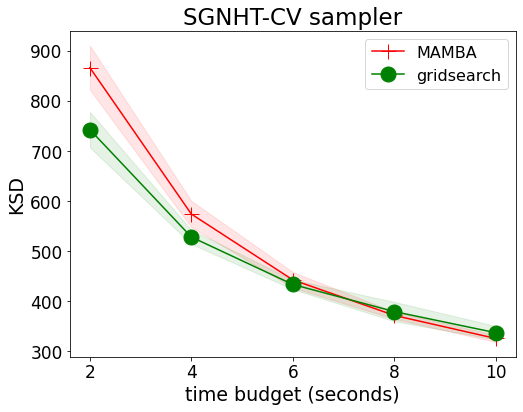

In [20]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")